In [1]:
# import needed packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import squarify
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
import patsy
from pandasql import sqldf

In [2]:
# Set notebook environment
pysqldf = lambda q: sqldf(q, globals())
%precision %.3f
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams["figure.figsize"] = 10,8

In [3]:
# Load text file into a local variable
columns = ['customer_id', 'purchase_amount', 'date_of_purchase']
df = pd.read_csv('purchases.txt', header=None, sep='\t',
            names=columns)
# interpret the last column as datetime
df['date_of_purchase'] = pd.to_datetime(df['date_of_purchase'], 
                                        format='%Y-%m-%d')
# Extract year of purchase and save it as a column
df['year_of_purchase'] = df['date_of_purchase'].dt.year
df.sample(n=5, random_state=57)

,customer_id,purchase_amount,date_of_purchase,year_of_purchase
4510,8060,30.00,2014-12-24,2014
17761,109180,50.00,2009-11-25,2009
39110,9830,30.00,2007-06-12,2007
37183,56400,60.00,2009-09-30,2009
33705,41290,60.00,2007-08-21,2007


In [4]:
# Add a day_since column showing the difference between last purchase and a basedate
basedate = pd.Timestamp('2016-01-01')
df['days_since'] = (basedate - df['date_of_purchase']).dt.days

--------

# Segment customers in 2015

In [5]:
# Segment customers in 2015
q = """
        SELECT customer_id,
        MIN(days_since) AS 'recency',
        MAX(days_since) AS 'first_purchase',
        COUNT(*) AS 'frequency',
        AVG(purchase_amount) AS 'amount'
        FROM df GROUP BY 1"""
customers_2015 = sqldf(q)

In [6]:
customers_2015.loc[customers_2015['recency'] > 365*3, 'segment'] = 'inactive'
customers_2015['segment'] =  customers_2015['segment'].fillna('NA')
customers_2015.loc[(customers_2015['recency']<= 365*3) & 
                   (customers_2015['recency'] > 356*2), 'segment'] = "cold"
customers_2015.loc[(customers_2015['recency']<= 365*2) & 
                   (customers_2015['recency'] > 365*1), 'segment'] = "warm"
customers_2015.loc[customers_2015['recency']<= 365, 'segment'] = "active"
customers_2015.loc[(customers_2015['segment'] == "warm") &
                  (customers_2015['first_purchase'] <= 365*2), 'segment'] = "new warm"
customers_2015.loc[(customers_2015['segment'] == "warm") &
                  (customers_2015['amount'] < 100), 'segment'] = "warm low value"
customers_2015.loc[(customers_2015['segment'] == "warm") &
                  (customers_2015['amount'] >= 100), 'segment'] = "warm high value"
customers_2015.loc[(customers_2015['segment'] == "active") &
                  (customers_2015['first_purchase'] <= 365), 'segment'] = "new active"
customers_2015.loc[(customers_2015['segment'] == "active") &
                  (customers_2015['amount'] < 100), 'segment'] = "active low value"
customers_2015.loc[(customers_2015['segment'] == "active") &
                  (customers_2015['amount'] >= 100), 'segment'] = "active high value"

In [7]:
# Transform segment column datatype from object to category
customers_2015['segment'] = customers_2015['segment'].astype('category')
# Re-order segments in a better readable way
sorter = ['inactive', 'cold', 'warm high value','warm low value', 
           'new warm', 'active high value', 'active low value',
           'new active']
customers_2015.segment.cat.set_categories(sorter, inplace=True)
customers_2015.sort_values(["segment"], inplace=True)

-----

# Segment customers in 2014

In [8]:
# Segment customers in 2014
q = """
        SELECT customer_id,
        MIN(days_since) - 365 AS 'recency',
        MAX(days_since) - 365 AS 'first_purchase',
        COUNT(*) AS 'frequency',
        AVG(purchase_amount) AS 'amount'
        FROM df
        WHERE days_since > 365
        GROUP BY 1"""

customers_2014 = sqldf(q)

In [9]:
customers_2014.loc[customers_2014['recency'] > 365*3, 'segment'] = 'inactive'
customers_2014['segment'] =  customers_2014['segment'].fillna('NA')
customers_2014.loc[(customers_2014['recency']<= 365*3) & 
                   (customers_2014['recency'] > 356*2), 'segment'] = "cold"
customers_2014.loc[(customers_2014['recency']<= 365*2) & 
                   (customers_2014['recency'] > 365*1), 'segment'] = "warm"
customers_2014.loc[customers_2014['recency']<= 365, 'segment'] = "active"
customers_2014.loc[(customers_2014['segment'] == "warm") &
                  (customers_2014['first_purchase'] <= 365*2), 'segment'] = "new warm"
customers_2014.loc[(customers_2014['segment'] == "warm") &
                  (customers_2014['amount'] < 100), 'segment'] = "warm low value"

customers_2014.loc[(customers_2014['segment'] == "warm") &
                  (customers_2014['amount'] >= 100), 'segment'] = "warm high value"
customers_2014.loc[(customers_2014['segment'] == "active") &
                  (customers_2014['first_purchase'] <= 365), 'segment'] = "new active"

customers_2014.loc[(customers_2014['segment'] == "active") &
                  (customers_2014['amount'] < 100), 'segment'] = "active low value"

customers_2014.loc[(customers_2014['segment'] == "active") &
                  (customers_2014['amount'] >= 100), 'segment'] = "active high value"

In [10]:
# Transform segment column datatype from object to category
customers_2014['segment'] = customers_2014['segment'].astype('category')
# Re-order segments in a better readable way
sorter = ['inactive', 'cold', 'warm high value','warm low value', 
           'new warm', 'active high value', 'active low value',
           'new active']
customers_2014.segment.cat.set_categories(sorter, inplace=True)
customers_2014.sort_values(["segment"], inplace=True)

-----

# Compute Transition Matrix

In [11]:
# Compute Transition Matrix
new_data = customers_2014.merge(customers_2015, how='left', on='customer_id')

In [12]:
new_data.tail()

,customer_id,recency_x,first_purchase_x,frequency_x,amount_x,segment_x,recency_y,first_purchase_y,frequency_y,amount_y,segment_y
16900,221470,236,236,1,15.00,new active,601,601,1,15.00,new warm
16901,221460,236,236,1,30.00,new active,147,601,2,30.00,active low value
16902,221450,236,236,1,45.00,new active,601,601,1,45.00,new warm
16903,221430,236,236,1,45.00,new active,601,601,1,45.00,new warm
16904,245840,48,48,1,50.00,new active,413,413,1,50.00,new warm


In [13]:
# We are going to cross segments 2014 and 2015 and see how many people are
# in both an meet this criterium
transition = pd.crosstab(new_data['segment_x'], new_data['segment_y'])
print(transition)

segment_y          inactive  cold  warm high value  warm low value  new warm  \
segment_x                                                                      
inactive               7227     0                0               0         0   
cold                   1931     0                0               0         0   
warm high value           0    75                0               0         0   
warm low value            0   689                0               0         0   
new warm                  0  1139                0               0         0   
active high value         0     0              119               0         0   
active low value          0     0                0             901         0   
new active                0     0                0               0       938   

segment_y          active high value  active low value  
segment_x                                               
inactive                          35               250  
cold                        

In [14]:
transition = transition.apply(lambda x: x/x.sum(), axis=1)

In [15]:
print(transition)

segment_y          inactive  cold  warm high value  warm low value  new warm  \
segment_x                                                                      
inactive               0.96  0.00             0.00            0.00      0.00   
cold                   0.90  0.00             0.00            0.00      0.00   
warm high value        0.00  0.68             0.00            0.00      0.00   
warm low value         0.00  0.72             0.00            0.00      0.00   
new warm               0.00  0.91             0.00            0.00      0.00   
active high value      0.00  0.00             0.25            0.00      0.00   
active low value       0.00  0.00             0.00            0.30      0.00   
new active             0.00  0.00             0.00            0.00      0.65   

segment_y          active high value  active low value  
segment_x                                               
inactive                        0.00              0.03  
cold                        

In [17]:
# The only thing we need to do is to use the transition matrix to estimate
# how customers will evolve

------------

# Use Transition Matrix To Make Predictions

In [19]:
# Initialize a placeholder matrix with then number of customers in each segment today
# and after 10 periods.
# The number of rows is the number of segments we have
# The number of columns is the number of years we are going to predict - 
# The evolution of segment membership
segments = np.zeros(shape=(8,11))

In [21]:
# 1st thing to do is to populate the first columns with then number of
# customers in each segment at the end of 2015
segments[:, 0] = customers_2015['segment'].value_counts(sort=False)

# 2nd Give each column the name of its corresponding year 
# and row the name of its corresponding segment:
segments = pd.DataFrame(segments, columns=np.arange(2015,2026), index=customers_2015['segment'].values.categories)

,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
inactive,"9,158.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [22]:
segments.head()

,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
inactive,"9,158.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
cold,"1,903.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
warm high value,119.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
warm low value,901.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
new warm,938.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [27]:
# Compute for each an every period
for i in range(2016, 2026):
    segments[i] = segments[i-1].dot(transition).round(0)
    segments[i].fillna(0, inplace=True)
    
# Noneed for float64 since we are rounding the results:
segments = segments.astype(int)

,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
inactive,9158,10517,11539,12636,12940,13185,13386,13542,13664,13760,13834
cold,1903,1584,1711,874,821,782,740,709,685,665,651
warm high value,119,144,165,160,157,152,149,146,143,141,139
warm low value,901,991,1058,989,938,884,844,813,789,771,756
new warm,938,987,0,0,0,0,0,0,0,0,0


In [29]:
segments.head(10)

,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
inactive,9158,10517,11539,12636,12940,13185,13386,13542,13664,13760,13834
cold,1903,1584,1711,874,821,782,740,709,685,665,651
warm high value,119,144,165,160,157,152,149,146,143,141,139
warm low value,901,991,1058,989,938,884,844,813,789,771,756
new warm,938,987,0,0,0,0,0,0,0,0,0
active high value,573,657,639,625,608,594,582,571,562,554,548
active low value,3313,3537,3306,3134,2954,2820,2717,2637,2575,2527,2490
new active,1512,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

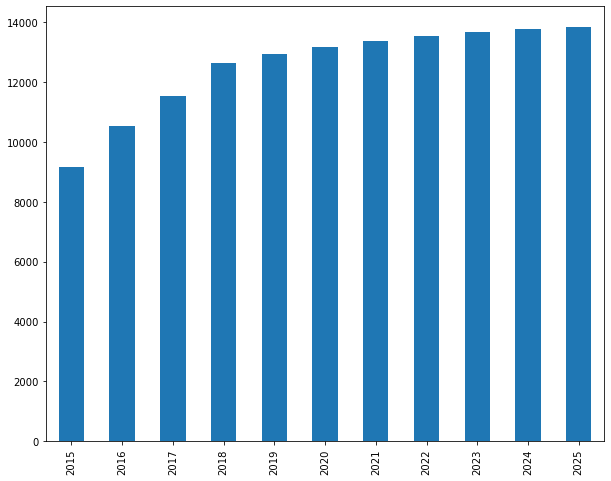

In [30]:
# Plot inactive customers over time
segments.iloc[0].plot(kind='bar')

<AxesSubplot:>

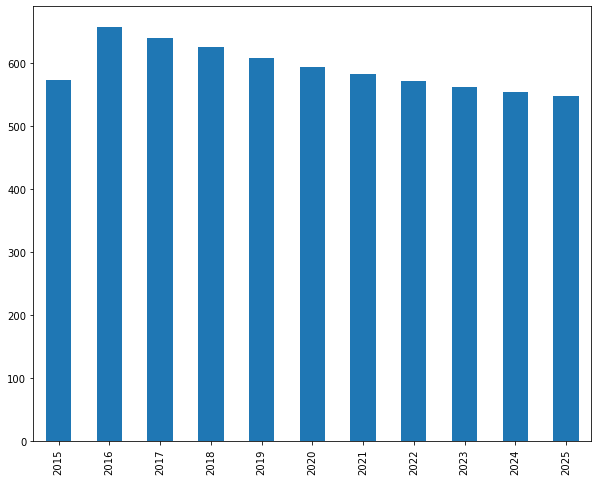

In [31]:
# Plot active high value customers over time
segments.iloc[5].plot(kind='bar')

-----

# Assigning and Discounting Revenue (CLV)

In [32]:
# Yearly revenue per segment
# This comes directly from module 2, lines 160-161
yearly_revenue = [0, 0, 0, 0, 0, 323.57, 52.31, 79.17]

In [44]:
# Compute revenue per segment

* 1st Method
segments.T * yearly_revenueb

      inactive  cold  warm high value  warm low value  new warm  \
2015      0.00  0.00             0.00            0.00      0.00   
2016      0.00  0.00             0.00            0.00      0.00   
2017      0.00  0.00             0.00            0.00      0.00   
2018      0.00  0.00             0.00            0.00      0.00   
2019      0.00  0.00             0.00            0.00      0.00   
2020      0.00  0.00             0.00            0.00      0.00   
2021      0.00  0.00             0.00            0.00      0.00   
2022      0.00  0.00             0.00            0.00      0.00   
2023      0.00  0.00             0.00            0.00      0.00   
2024      0.00  0.00             0.00            0.00      0.00   
2025      0.00  0.00             0.00            0.00      0.00   

      active high value  active low value  new active  
2015         185,405.61        173,303.03  119,705.04  
2016         212,585.49        185,020.47        0.00  
2017         206,761.23    

In [45]:
# Compute revenue per segment
revenue_per_segment = segments.multiply(yearly_revenue, axis='index')
print(revenue_per_segment)

                        2015       2016       2017       2018       2019  \
inactive                0.00       0.00       0.00       0.00       0.00   
cold                    0.00       0.00       0.00       0.00       0.00   
warm high value         0.00       0.00       0.00       0.00       0.00   
warm low value          0.00       0.00       0.00       0.00       0.00   
new warm                0.00       0.00       0.00       0.00       0.00   
active high value 185,405.61 212,585.49 206,761.23 202,231.25 196,730.56   
active low value  173,303.03 185,020.47 172,936.86 163,939.54 154,523.74   
new active        119,705.04       0.00       0.00       0.00       0.00   

                        2020       2021       2022       2023       2024  \
inactive                0.00       0.00       0.00       0.00       0.00   
cold                    0.00       0.00       0.00       0.00       0.00   
warm high value         0.00       0.00       0.00       0.00       0.00   
warm low va

In [52]:
# Compute yearly revenue
yearly_revenue = revenue_per_segment.sum(axis=0).round(0)
yearly_revenue

2015   478,414.00
2016   397,606.00
2017   379,698.00
2018   366,171.00
2019   351,254.00
2020   339,715.00
2021   330,444.00
2022   322,700.00
2023   316,545.00
2024   311,445.00
2025   307,568.00
dtype: float64

<AxesSubplot:>

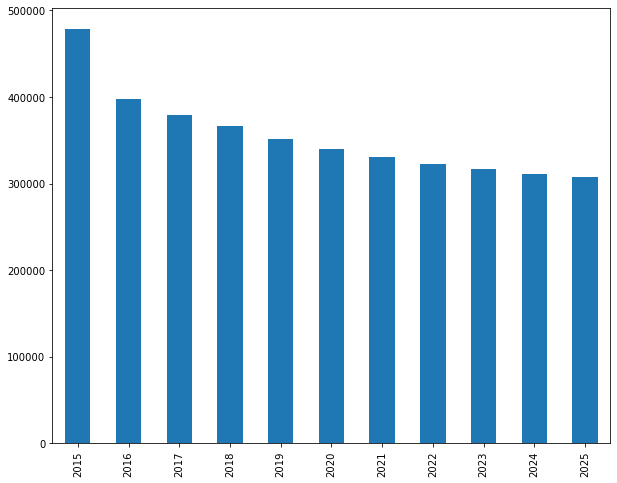

In [53]:
yearly_revenue.plot(kind='bar')

2015     478,414.00
2016     876,020.00
2017   1,255,718.00
2018   1,621,889.00
2019   1,973,143.00
2020   2,312,858.00
2021   2,643,302.00
2022   2,966,002.00
2023   3,282,547.00
2024   3,593,992.00
2025   3,901,560.00
dtype: float64


<AxesSubplot:>

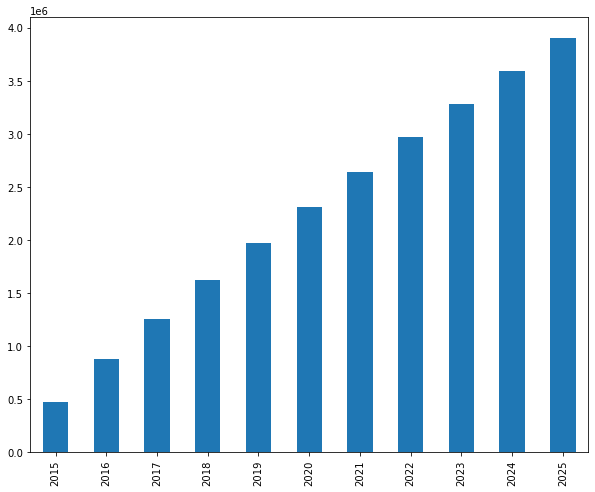

In [54]:
# Compute cumulated revenue
cumulated_revenue = yearly_revenue.cumsum(axis=0)
print(cumulated_revenue.round(0))
cumulated_revenue.plot(kind='bar')

In [56]:
# Create a discount factor
discount_rate = 0.10
discount = 1 / ((1 + discount_rate) ** np.arange(0,11))
print(discount)

[1.         0.90909091 0.82644628 0.7513148  0.68301346 0.62092132
 0.56447393 0.51315812 0.46650738 0.42409762 0.38554329]


2015   478,414.00
2016   361,460.00
2017   313,800.00
2018   275,110.00
2019   239,911.00
2020   210,936.00
2021   186,527.00
2022   165,596.00
2023   147,671.00
2024   132,083.00
2025   118,581.00
dtype: float64


<AxesSubplot:label='fe38a0f4-ad27-4877-a60d-27626ff5fab1'>

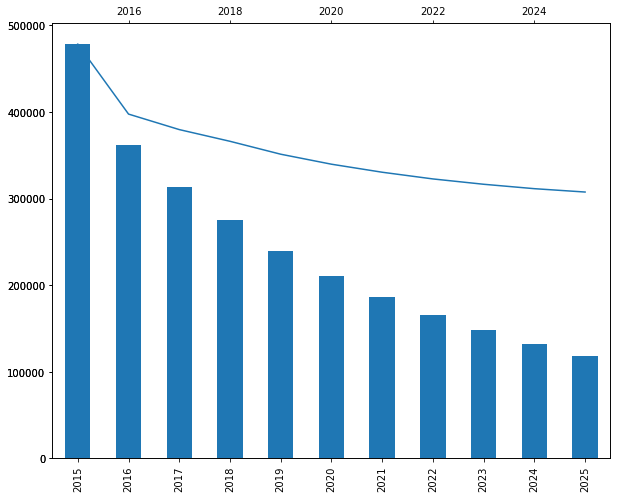

In [57]:
# Compute discounted yearly revenue
# Future revenues in todays money
disc_yearly_revenue = yearly_revenue.multiply(discount)
print(disc_yearly_revenue.round(0))
ax1 = disc_yearly_revenue.plot(kind='bar')
ax2 = ax1.twiny()
yearly_revenue.plot(kind='line', ax=ax2)

2015     478,414.00
2016     839,874.00
2017   1,153,674.00
2018   1,428,784.00
2019   1,668,695.00
2020   1,879,631.00
2021   2,066,158.00
2022   2,231,754.00
2023   2,379,425.00
2024   2,511,508.00
2025   2,630,089.00
dtype: float64


<AxesSubplot:>

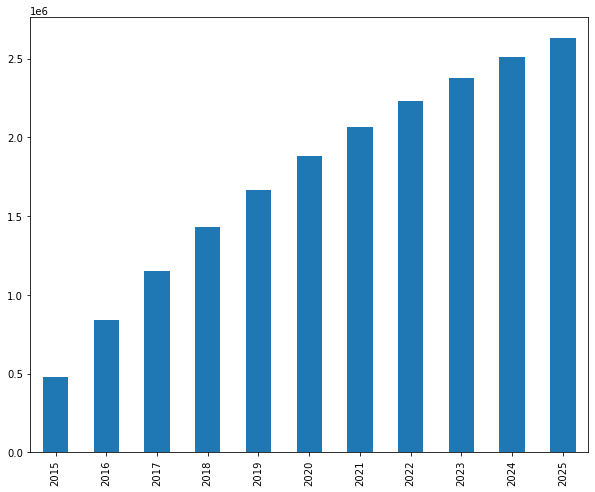

In [58]:
# Compute discounted cumulated revenue
disc_cumulated_revenue = disc_yearly_revenue.cumsum(axis=0)
print(disc_cumulated_revenue.round(0))
disc_cumulated_revenue.plot(kind='bar')

In [60]:
# What is the database worth?
#  What's the true value, the discounted cumulative value of my database 
# in terms of expected revenue of the next ten years
print((disc_cumulated_revenue[2025] - yearly_revenue[2015]).round(0))

2151675.0
